In [64]:
import pandas as pd
import numpy as np
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

DATA_FLOW = 'local'
DATA_SAMPLE = 0.15
SAMPLE_OUTLIERS = 0.75

def preprocess(text):
    text = text.replace('\n', ' ')
    text = text.replace(u'\xa0', u' ')
    text = text.replace('@', '')
    new_text = []
    for t in text.split(" "):
        t = '' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Read news data
if DATA_FLOW == 'local':
    df = pd.read_csv("./../data/raw/news_tweets.csv")
elif DATA_FLOW == 'gcp':
    from google.cloud import storage
    from io import BytesIO
    client = storage.Client()
    bucket_name = "covid-news-response"
    file_name = "news_tweets.csv"
    bucket = client.get_bucket(bucket_name)
    blob = bucket.get_blob(file_name)
    content = blob.download_as_string()
    df = pd.read_csv(BytesIO(content))

# Clear news data
df.created_at = pd.to_datetime(df.created_at)
df['clean_text'] = df.text.apply(lambda x: preprocess(x))
df['moy'] = pd.to_datetime(
    df.created_at.dt.year.astype(str) + '-' + df.created_at.dt.month.astype(str) + '-1')
docs = df.sample(frac=DATA_SAMPLE, random_state=42).clean_text.values
timestamps = df.sample(frac=DATA_SAMPLE, random_state=42).moy.to_list()

# Constants
QUANTITY = len(docs)
MIN_CLUSTER_SIZE = int(np.ceil(QUANTITY * 0.0005))
N_NEIGHBORS = int(np.ceil(MIN_CLUSTER_SIZE * 0.75))
MIN_SAMPLES = int(np.ceil((MIN_CLUSTER_SIZE * SAMPLE_OUTLIERS) * 0.95))
MIN_VECTORIZE = int(np.ceil(QUANTITY * 2e-05))

# Topic model
vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words="english", min_df=MIN_VECTORIZE)
umap_model = UMAP(n_neighbors=15, n_components=10, metric='cosine', low_memory=False)
hdbscan_model = HDBSCAN(min_cluster_size=MIN_CLUSTER_SIZE, min_samples=MIN_SAMPLES, metric='euclidean', prediction_data=True)
topic_model = BERTopic(
    language="english", nr_topics="auto", calculate_probabilities=False, verbose=True, low_memory=False,
    vectorizer_model=vectorizer_model, umap_model=umap_model, hdbscan_model=hdbscan_model,
)
topics, probs = topic_model.fit_transform(docs)
topics_over_time = topic_model.topics_over_time(docs, topics, timestamps)

Batches:   0%|          | 0/7712 [00:00<?, ?it/s]

2022-03-26 19:20:38,528 - BERTopic - Transformed documents to Embeddings
2022-03-26 19:24:35,435 - BERTopic - Reduced dimensionality with UMAP
2022-03-26 19:25:48,310 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-03-26 19:26:43,767 - BERTopic - Reduced number of topics from 285 to 176
24it [00:49,  2.04s/it]


### Check topics

In [65]:
freq = topic_model.get_topic_info()
print("The number of documents is:", QUANTITY)
print("The number of identified topics is:", len(freq))
print("The percentage of outlier documents is:", np.round(freq[freq.Topic==-1]['Count'].values[0]/QUANTITY,2))
freq.head(5)

The number of documents is: 246783
The number of identified topics is: 176
The percentage of outlier documents is: 0.45


,Topic,Count,Name
0,-1,111027,-1_covid19_coronavirus_covid_lockdown
1,0,8192,0_vaccine_vaccination_vaccines_india
2,1,6886,1_tokyo_players_olympics_league
3,2,6322,2_schools_school_students_education
4,3,6315,3_victoria_nsw_australia_7news


In [66]:
topic_model.get_topic(0)

[('vaccine', 0.01881742336953216),
 ('vaccination', 0.014259073823526945),
 ('vaccines', 0.013942265442844314),
 ('india', 0.012067817000911397),
 ('doses', 0.011564063075870842),
 ('drive', 0.009388665435109786),
 ('covid19 vaccine', 0.009356262129383513),
 ('crore', 0.008479358901564468),
 ('vaccination drive', 0.007834851663064623),
 ('administered', 0.007512596330037813)]

### Visualize topics

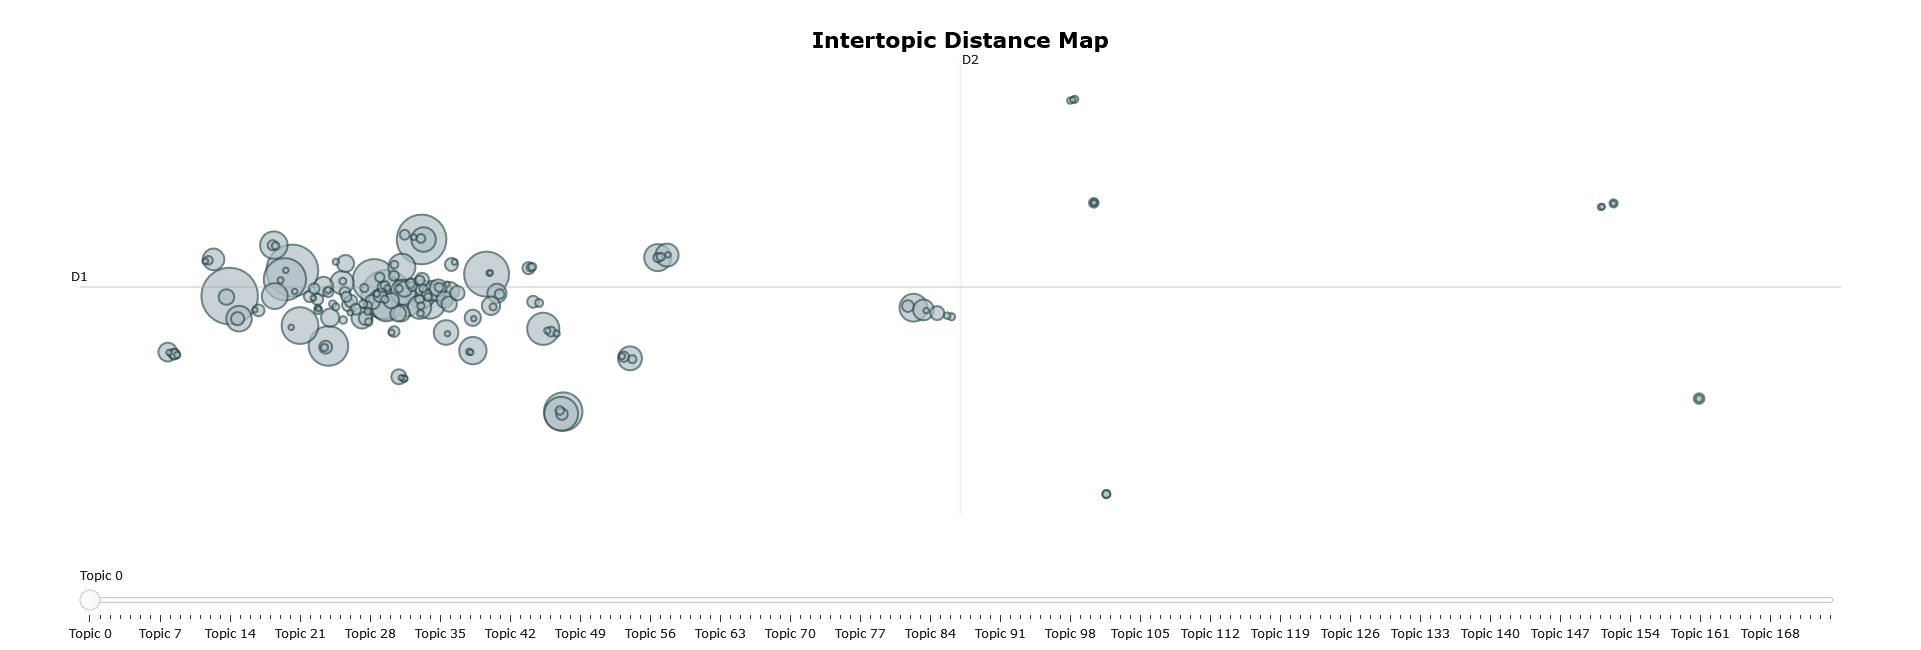

In [67]:
topic_model.visualize_topics()

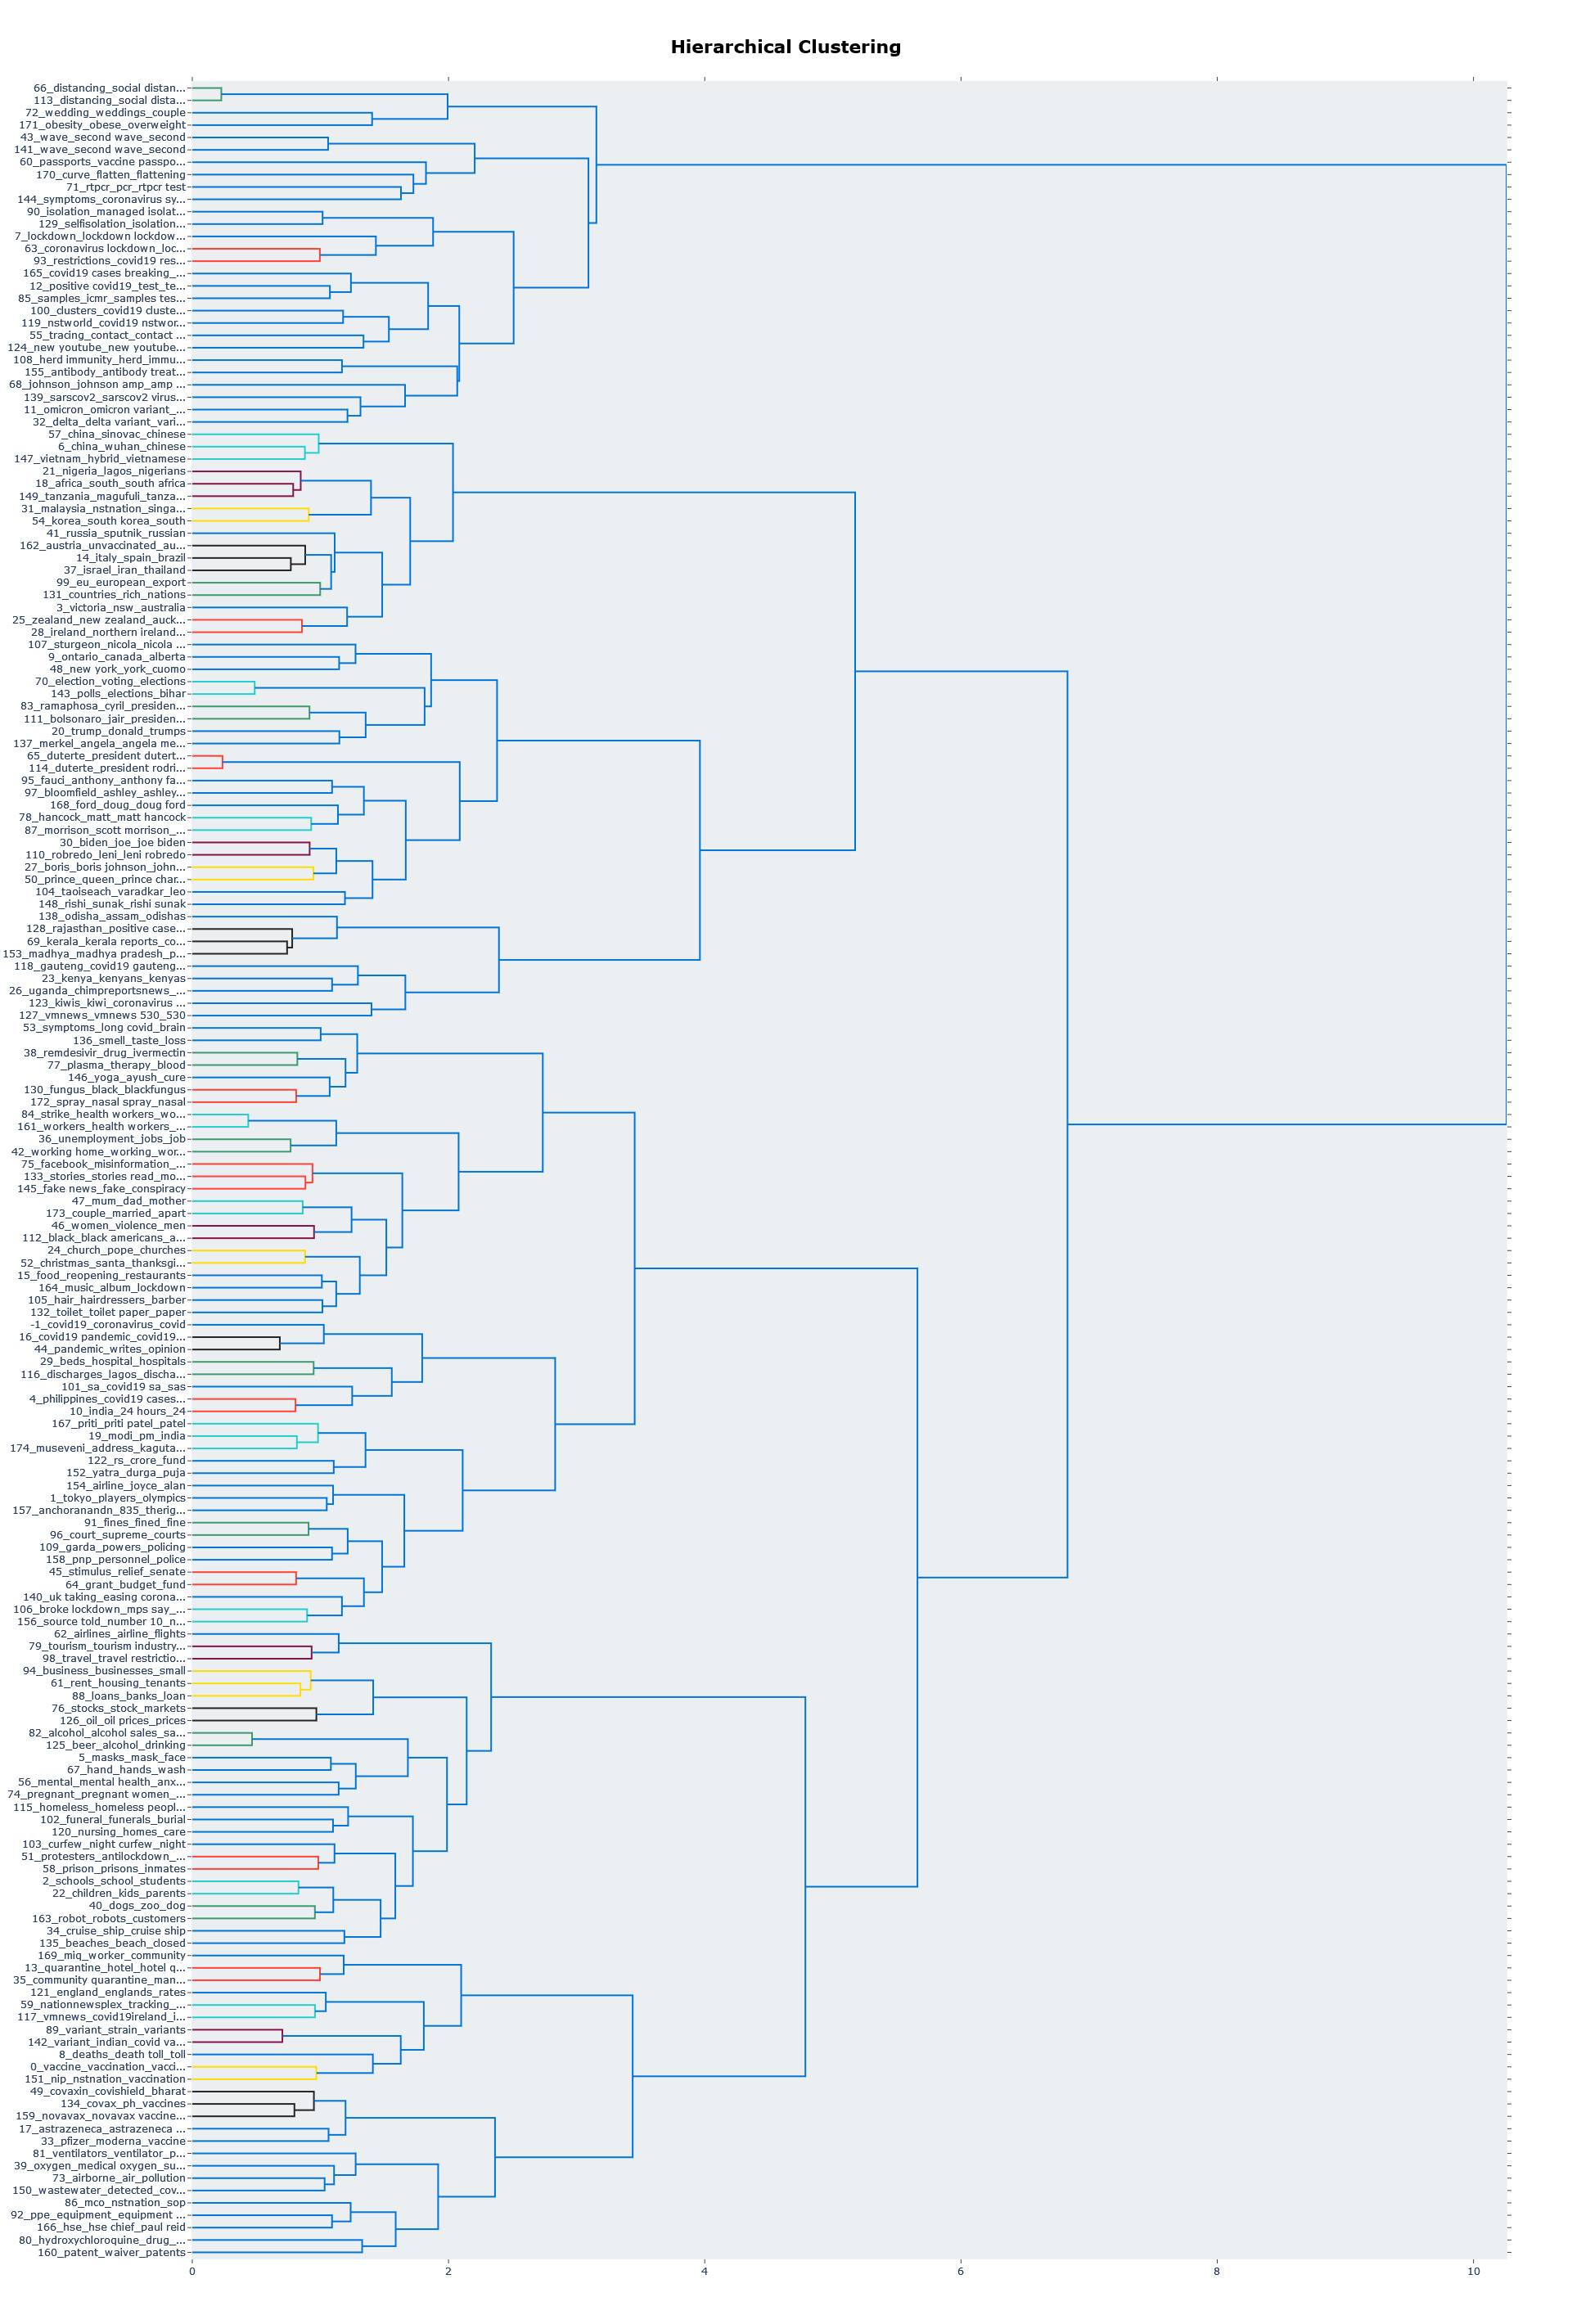

In [68]:
topic_model.visualize_hierarchy()

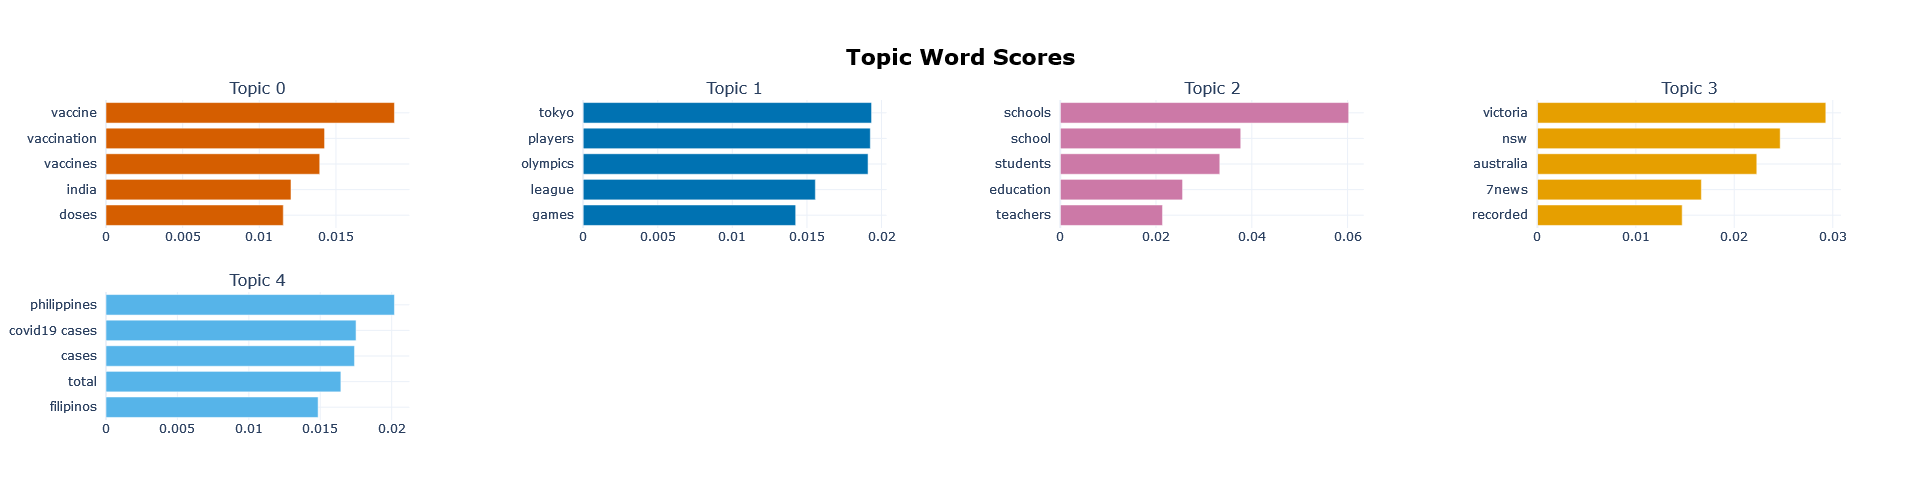

In [69]:
topic_model.visualize_barchart(top_n_topics=5)

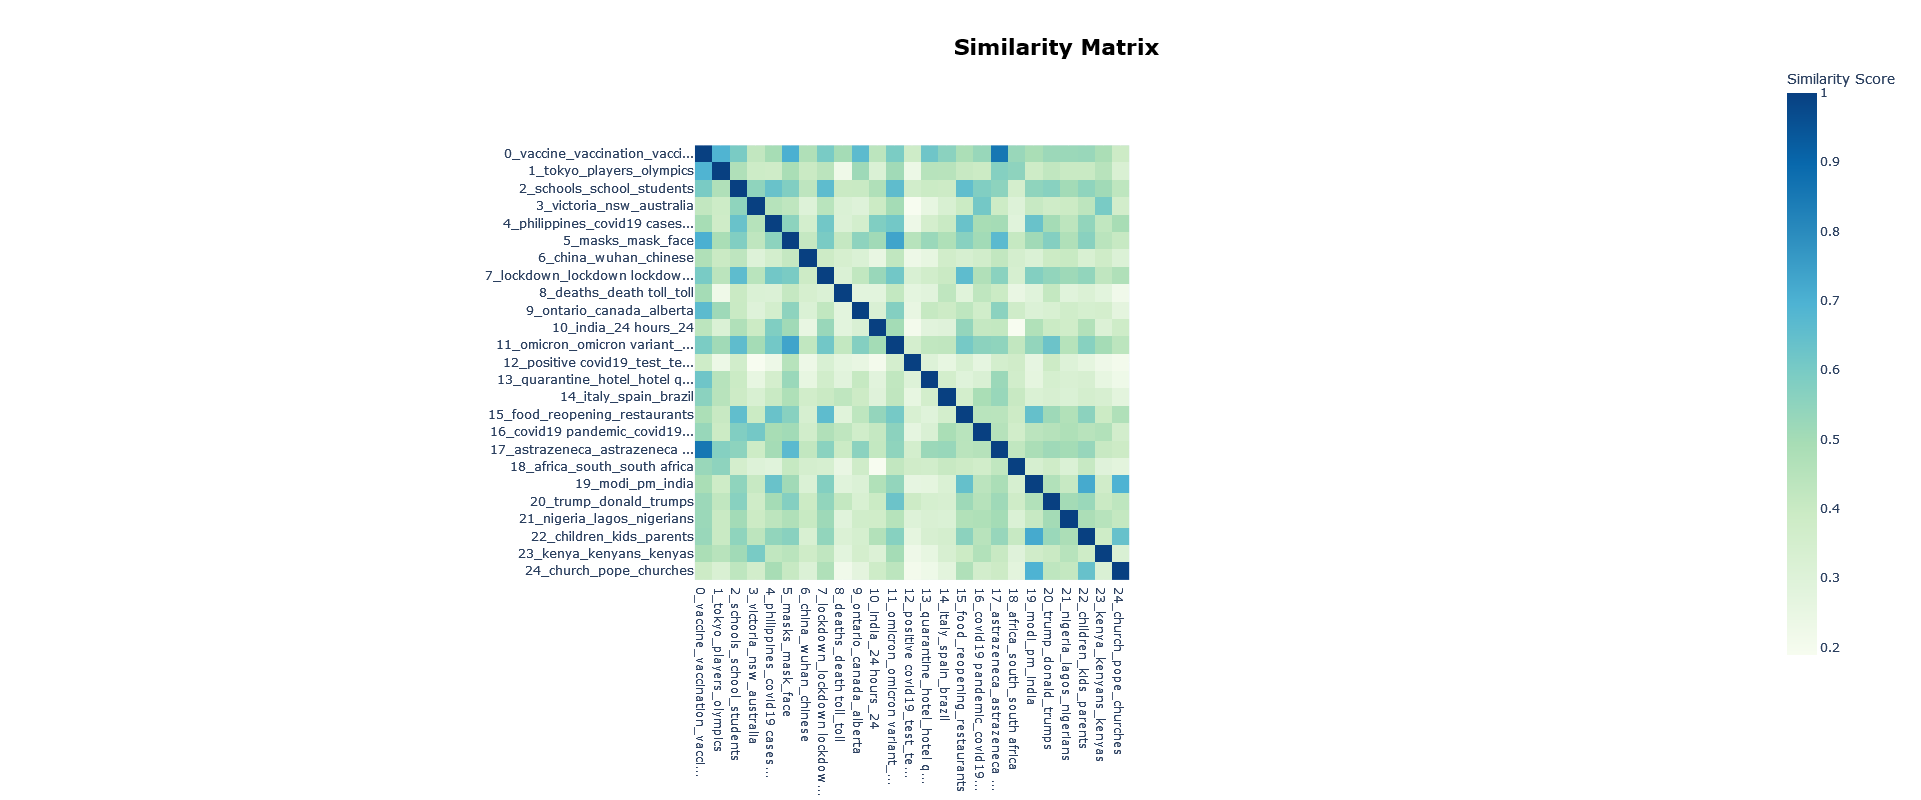

In [70]:
topic_model.visualize_heatmap(top_n_topics=25)

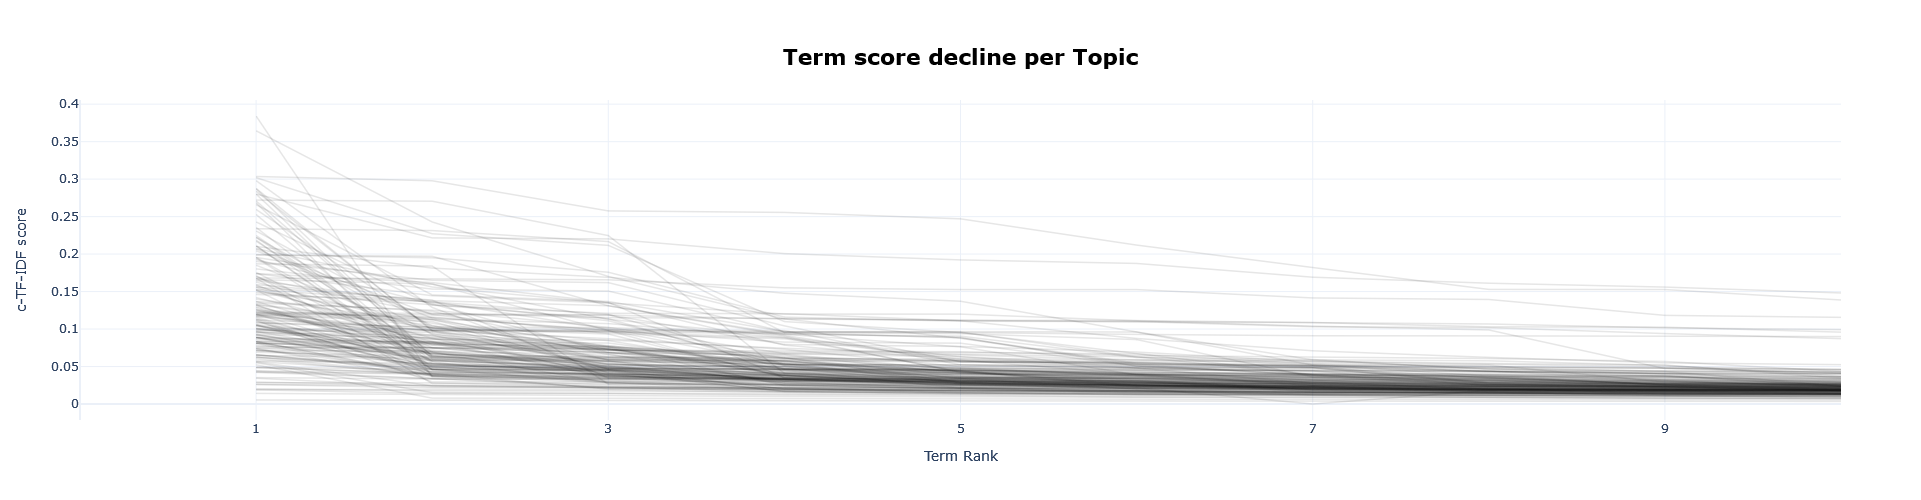

In [71]:
topic_model.visualize_term_rank()

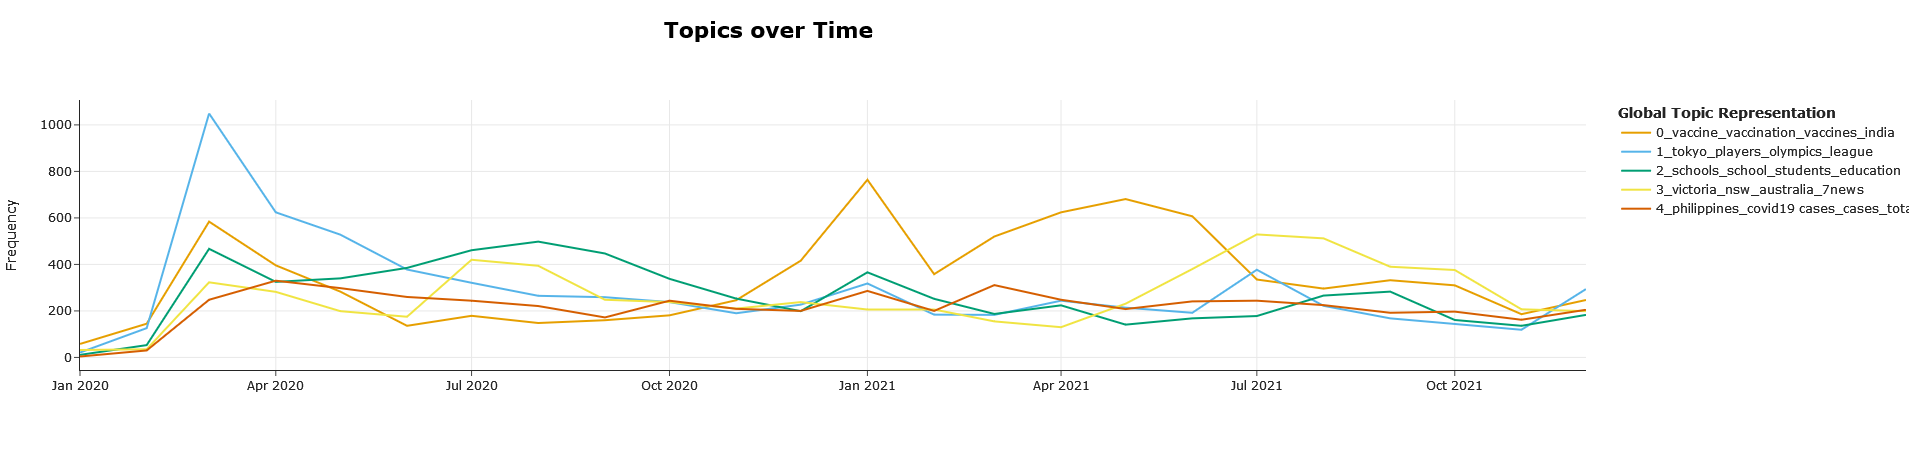

In [72]:
topic_model.visualize_topics_over_time(topics_over_time, topics=[0,1,2,3,4])